In [1]:
import os


<h1> Deep Variational Autoencoder</h1>
# For 1D unbalanced classification problem
## Semi-supervised Churn Customer Prediction
* The project were written for kaggle Churn prediction competition
* WSDM - KKBox's Churn Prediction Challenge
* https://www.kaggle.com/c/kkbox-churn-prediction-challenge</br>
### <b>The work plan:</b>
1. Read the data and create dummy variables for the catecorial fetures.
2. Create, and train variational autoencoder, that decode the data into a 2 dimentional latent space.
3. View the data in the latent 2D space, and check classification astrategies.</br>
### <b>Reference to Variational Auto encoder:</b>
* https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/</br>
### <b>The Data:</b>
* The data can be downloaded at the kaggle competition website.
* Data reading, aggregation and feture engeeniring, here: https://github.com/naomifridman/Neural-Network-Churn-Prediction. Small data sample can be found here as well.


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import collections

# For plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

## Read Data
#### train_data.csv - the train set, of kaggle competition, after feature ingeneering.
* msno: user id
* is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.

In [4]:
test=pd.read_csv('test_data.csv')
train= pd.read_csv('train_data.csv')

In [5]:
print train.columns
from sklearn.utils import shuffle
train = shuffle(train)

Index([u'msno', u'is_churn', u'trans_count', u'payment_method_id',
       u'payment_plan_days', u'plan_list_price', u'actual_amount_paid',
       u'is_auto_renew', u'transaction_date', u'membership_expire_date',
       u'is_cancel', u'logs_count', u'date', u'num_25', u'num_50', u'num_75',
       u'num_985', u'num_100', u'num_unq', u'total_secs', u'city', u'bd',
       u'gender', u'registered_via', u'registration_init_time'],
      dtype='object')


In [6]:
train.head()

,msno,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,...,num_75,num_985,num_100,num_unq,total_secs,city,bd,gender,registered_via,registration_init_time
448226,PpcGaLDnaqbR0rFnSjE1ePlq8Iwg+I/496p/3C1sk6M=,0,5,41.0,30.0,99.0,99.0,1.0,20170310.0,20170410.0,...,1.0,0.0,73.0,76.0,19664.449,5.0,23.0,1.0,7.0,20161110.0
23523,3mbiROk+stv5bpSoSBamETsOdsGvI2tYkizEyt5NLE4=,1,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,39.0,40.0,10252.677,15.0,22.0,1.0,9.0,20150825.0
121396,uYcPOte+AR3WoaBIyf/ZRMYw0lggV7SFLdgpQJHcsgg=,0,27,36.0,30.0,180.0,180.0,1.0,20170312.0,20170411.0,...,1.0,0.0,0.0,2.0,126.171,22.0,21.0,2.0,7.0,20150307.0
984074,YWiGHcibaJjX3HvGhHnvtm4YFWOAtaq+EqcEC9x1b+A=,0,22,39.0,30.0,149.0,149.0,1.0,20170331.0,20170505.0,...,0.0,1.0,25.0,33.0,6721.551,5.0,36.0,2.0,9.0,20100326.0
1900366,Y1hlZ5xC1BHdsayrSBRS7qjQ81aEbNIA8vWr9zuPL1M=,0,17,41.0,30.0,100.0,100.0,1.0,20170331.0,20170430.0,...,1.0,0.0,150.0,121.0,35802.106,1.0,0.0,0.0,7.0,20160107.0


## Visualize and Analize data functionality

In [7]:
def agg_col_by_chrn(dfo, col, drow = True):
    
    h = dfo.groupby([col,'is_churn']).agg(len)
    v= h.msno

    dn =pd.DataFrame()
    dn['not'] = v.loc[pd.IndexSlice[:,0]]
    dn['churn']= v.loc[pd.IndexSlice[:,1]]
    dn = dn.fillna(0.)
    if (drow):
        dn.plot(kind='bar', stacked=True, color=['b','y'])
        plt.title(col)
    dn['percent'] = dn.churn * 100. / (dn['not'] +  dn.churn)
    dn['sum'] = dn.churn +(dn['not'])
    dn = dn.sort_values('percent')
    dn = dn.reset_index()
    return dn

In [8]:
def agg_col(dfo, col, drow = True):
    
    h = test.groupby([col,'is_churn']).agg(len)
    v= h.msno

    dn =pd.DataFrame()
    dn['sum'] = v.loc[pd.IndexSlice[:,0]]
    dn = dn.fillna(0.)
    if (drow):
        dn.plot(kind='bar', stacked=True, color=['b','y'])
        plt.title(col)
    dn = dn.reset_index()
    return dn

In [9]:
def drow_col(df, col):
    
    
    dft = train[[col,'is_churn']]
    dft0 = dft[dft.is_churn==0]
    dft1 = dft[dft.is_churn==1]

    sns.kdeplot(dft0[col], label='not churn', shade=True)
    sns.kdeplot(dft1[col], label='churn', shade=True)
    
    plt.xlabel(col);


## Handle categorial features
* There are few categorial features in the data set. Lets view them and create dummy variables.

In [10]:
def order_col_by_churn_percent(col,drow=True):
    
    dn = agg_col_by_chrn(train, col, drow = False)
    tmp = dn[[col]].to_dict()
    val_map=  tmp[col]

    inv_map = {v: k for k, v in val_map.items()}

    train[col] = train[col].replace(inv_map)
    test[col] = test[col].replace(inv_map)
    if (drow) :
        drow_col(train, col)

### registered_via

In [11]:
col= 'registered_via'
print 'registered_via', collections.Counter(train['registered_via'])

registered_via Counter({7.0: 945410, 9.0: 472309, 0.0: 225763, 3.0: 211904, 4.0: 102027, 13.0: 6478})


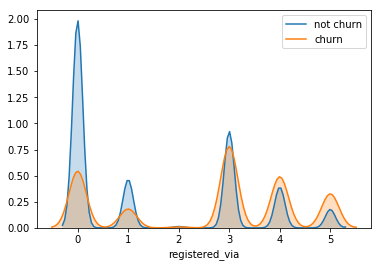

In [12]:
order_col_by_churn_percent(col)

### payment_method_id


In [13]:
col = 'payment_method_id'
print 'city',collections.Counter(train[col])

city Counter({41.0: 1096538, 40.0: 145608, 36.0: 130614, 39.0: 128210, 0.0: 93166, 38.0: 79695, 37.0: 74482, 34.0: 57618, 30.0: 30987, 33.0: 28344, 29.0: 28074, 31.0: 20694, 32.0: 17269, 15.0: 4338, 23.0: 4190, 27.0: 3718, 35.0: 3435, 28.0: 3240, 19.0: 2588, 20.0: 1866, 21.0: 1758, 16.0: 1588, 18.0: 1272, 22.0: 1144, 14.0: 1085, 13.0: 823, 17.0: 616, 12.0: 490, 26.0: 171, 11.0: 150, 10.0: 74, 8.0: 21, 6.0: 14, 3.0: 11})


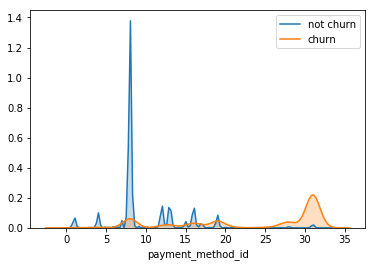

In [14]:
order_col_by_churn_percent(col)

### city

In [15]:
col = 'city'
print 'city',collections.Counter(train[col])

city Counter({1.0: 897987, 0.0: 225763, 13.0: 195417, 5.0: 142005, 4.0: 95172, 15.0: 86543, 22.0: 84120, 6.0: 52088, 14.0: 40180, 12.0: 22937, 9.0: 19084, 11.0: 18174, 18.0: 15634, 8.0: 15279, 10.0: 13003, 17.0: 11022, 21.0: 10485, 3.0: 10146, 7.0: 5318, 16.0: 1900, 20.0: 1354, 19.0: 280})


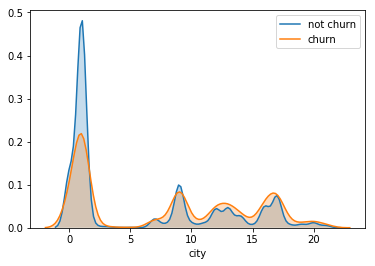

In [16]:
order_col_by_churn_percent(col)

### gender


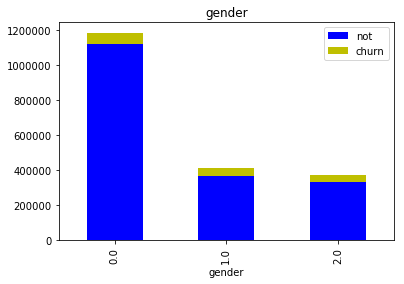

In [17]:
col = 'gender'
dn = agg_col_by_chrn(train, col)

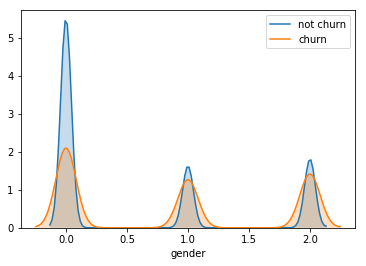

In [18]:
order_col_by_churn_percent('gender')

### Encode Categorial Features
Create dummy feature for each category.
We will not applt this on payment_method_id, becausea there are a lot of values,
and we will get big sparse matrix.

In [19]:
def aply_oonehot(df, col):
    df_en = pd.get_dummies(df[col])
    
    df_en = df_en.drop(df_en.columns[0], 1)
    
    cols = [str(col)+'_'+str(c) for c in df_en.columns]
    df_en.columns = cols
    
    df = df.drop(col, 1)
    
    
    df = pd.concat([df, df_en], axis=1)
    return df

In [20]:
train = aply_oonehot(train, 'city')
test =  aply_oonehot(test, 'city')

train = aply_oonehot(train, 'registered_via')
test =  aply_oonehot(test, 'registered_via')

train = aply_oonehot(train, 'gender')
test =  aply_oonehot(test, 'gender')

In [21]:
# will not create dummy fetures for payment_method_id, because there are many categories, 
# and we will get big spars matrix
print train.columns

Index([u'msno', u'is_churn', u'trans_count', u'payment_method_id',
       u'payment_plan_days', u'plan_list_price', u'actual_amount_paid',
       u'is_auto_renew', u'transaction_date', u'membership_expire_date',
       u'is_cancel', u'logs_count', u'date', u'num_25', u'num_50', u'num_75',
       u'num_985', u'num_100', u'num_unq', u'total_secs', u'bd',
       u'registration_init_time', u'city_1.0', u'city_2.0', u'city_3.0',
       u'city_4.0', u'city_5.0', u'city_6.0', u'city_7.0', u'city_8.0',
       u'city_9.0', u'city_10.0', u'city_11.0', u'city_12.0', u'city_13.0',
       u'city_14.0', u'city_15.0', u'city_16.0', u'city_17.0', u'city_18.0',
       u'city_19.0', u'city_20.0', u'city_21.0', u'registered_via_1.0',
       u'registered_via_2.0', u'registered_via_3.0', u'registered_via_4.0',
       u'registered_via_5.0', u'gender_1.0', u'gender_2.0'],
      dtype='object')


## Model evaluation and visualization functions

In [22]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score, log_loss

def print_stats(ytest, ypred):
    
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    ll = log_loss(ytest, ypred)
    print("Log Loss: {}".format(ll))
    print ' '
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred))

In [23]:
def drow_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.title('ROC Curve - Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'g--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show();

In [24]:
def drow_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+ metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()    

# VAE - variational autoencoder
* refernce: https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/

Since vae neural net is highly customized, data set size must be devided bt batch size 

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

XX_train, XX_val = train_test_split(train, test_size=589200)

cols = [c for c in train.columns if c not in ['is_churn','msno']]

X_train = MinMaxScaler().fit_transform(XX_train[cols])
y_train = XX_train['is_churn'].as_matrix()
XX_val1 = MinMaxScaler().fit_transform(XX_val[cols])
yy_val1= XX_val['is_churn'].as_matrix()
X_real_test = MinMaxScaler().fit_transform(test[cols])
print y_train.shape, yy_val1.shape

(1374691,) (589200,)


* Lets split validation set to validation and train sets

In [28]:
X_val, X_test, y_val, y_test = train_test_split(XX_val1, yy_val1, test_size=294600, random_state=42)
print y_train.shape, y_val.shape, y_test.shape, train.shape

(1374691,) (294600,) (294600,) (1963891, 50)


Since vae neural net is highly customized, data set size must be devided bt batch size 

In [30]:
def cut_array_to_fit_batchsize(X,y,batch_size):
    n_size = (len(X)//batch_size)*batch_size
    
    X = X[0:n_size]
    
    y = y[0:n_size]
    return X, y

In [31]:
batch_size = 100

X_train, y_train = cut_array_to_fit_batchsize(X_train,y_train, batch_size)
X_val, y_val = cut_array_to_fit_batchsize(X_val, y_val, batch_size)

X_test,y_test = cut_array_to_fit_batchsize(X_test,y_test, batch_size)
y_real_test=np.zeros((len(X_real_test)))
print X_val.shape, X_train.shape


(294600, 48) (1374600, 48)


## Vaeuational autoencoder creation

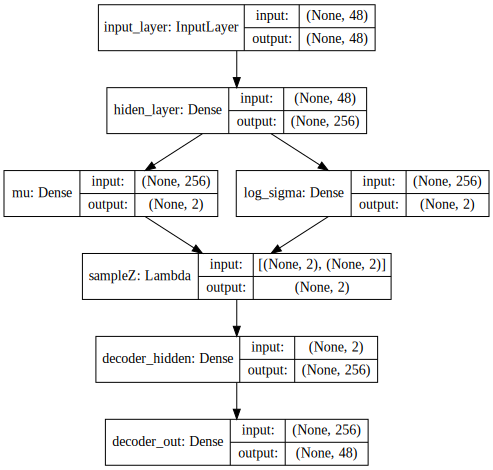

In [32]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras.backend as K
from numpy.random import seed
seed(1)

# Define input layer
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,), name='input_layer')

# Define Encoder layers
hiden_layer_dim = 256
hiden_layer = Dense(hiden_layer_dim, activation='relu', 
            name='hiden_layer')(input_layer)

# Create 2 dense layer that outputs latent space dimention data
latent_space_dim = 2
mu = Dense(latent_space_dim, activation='linear', name='mu')(hiden_layer)
log_sigma = Dense(latent_space_dim, activation='linear', name='log_sigma')(hiden_layer)

# Encoder model, to encode input into latent variable
# We choose mu, the mean of the output as can be seen in the samle_z function.
# the mean is the center point, the representative of the gaussian
encoder = Model(input_layer, mu, name='encoder')

# Now the trick of the vae, to sample from the 2 dense layers
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(batch_size, latent_space_dim), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps


# Sample from the output of the 2 dense layers
sampleZ = Lambda(sample_z, name='sampleZ', output_shape=(latent_space_dim,))([mu, log_sigma])

# Define decoder layers in VAE model
decoder_hidden = Dense(hiden_layer_dim, activation='relu', name='decoder_hidden') 
decoder_out = Dense(input_dim, activation='sigmoid', name = 'decoder_out')

h_p = decoder_hidden(sampleZ)
output_layer = decoder_out(h_p)

# VAE model, Unsupervised leraning for reconstruction of the input data
vae = Model(input_layer, output_layer, name='vae')


# Define a separate Decoder model, that recostruct data from latent variable 
# The decoder model uses eights that was trained with the VAE mode;,
# We need a separate model, if we want to generate data from given data in latent space.
d_in = Input(shape=(latent_space_dim,), name='decoder_input')
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)

decoder = Model(d_in, d_out, name='decoder')

SVG(model_to_dot(vae, show_shapes='true').create(prog='dot', format='svg'))

In [33]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

    return recon + kl

In [34]:
from keras.callbacks import Callback
vlos = float(10000.)

class SaveBest(Callback):
    global vlos
    vlos = float(10000.)
    
    '''def on_train_begin(self, logs={}):
        vlos = float(10000.)'''

    def on_epoch_end(self, batch, logs={}):
        global vlos
        tmp = logs.get('val_loss')
        if (tmp==None):
            tmp = 1000.
        
        if (vlos - float(tmp) > 0.000001) :
            print 'loss improoved from: ', vlos, ' to: ', tmp, 'saving models'
            vlos = float(tmp)
            encoder.save('best_encoder.h5')
            decoder.save('best_decoder.h5')
            vae.save('best_vae.h5')
        

In [35]:
savebest = SaveBest()
vae.compile(optimizer='adam', loss=vae_loss)
vae_history = vae.fit(X_train, X_train, batch_size=batch_size, shuffle=True, 
                      validation_data = (X_val, X_val),
                    epochs=200, callbacks = [EarlyStopping(monitor='loss',patience = 8), savebest])

Train on 1374600 samples, validate on 294600 samples
Epoch 1/200
1374600/1374600 [==============================] - 57s - loss: 8.0833 - val_loss: 7.8557
Epoch 2/200
1374600/1374600 [==============================] - 63s - loss: 7.7609 - val_loss: 7.7591
Epoch 3/200
1374600/1374600 [==============================] - 67s - loss: 7.7060 - val_loss: 7.7312
Epoch 4/200
1374600/1374600 [==============================] - 71s - loss: 7.6763 - val_loss: 7.7037
Epoch 5/200
1374600/1374600 [==============================] - 72s - loss: 7.6572 - val_loss: 7.6880
Epoch 6/200
1374600/1374600 [==============================] - 77s - loss: 7.6477 - val_loss: 7.6840
Epoch 7/200
1374600/1374600 [==============================] - 86s - loss: 7.6408 - val_loss: 7.6780
Epoch 8/200
1374600/1374600 [==============================] - 93s - loss: 7.6319 - val_loss: 7.6662
Epoch 9/200
1374600/1374600 [==============================] - 93s - loss: 7.6280 - val_loss: 7.6691
Epoch 10/200
1374600/1374600 [========

1374600/1374600 [==============================] - 127s - loss: 7.5139 - val_loss: 7.5677
Epoch 49/200
1374600/1374600 [==============================] - 124s - loss: 7.5123 - val_loss: 7.5479
Epoch 50/200
1374600/1374600 [==============================] - 123s - loss: 7.5102 - val_loss: 7.5443
Epoch 51/200
1374600/1374600 [==============================] - 120s - loss: 7.5066 - val_loss: 7.5429
Epoch 52/200
1374600/1374600 [==============================] - 121s - loss: 7.5090 - val_loss: 7.5449
Epoch 53/200
1374600/1374600 [==============================] - 114s - loss: 7.5086 - val_loss: 7.5401
Epoch 54/200
1374600/1374600 [==============================] - 115s - loss: 7.5084 - val_loss: 7.5497
Epoch 55/200
1374600/1374600 [==============================] - 115s - loss: 7.5062 - val_loss: 7.5544
Epoch 56/200
1374600/1374600 [==============================] - 113s - loss: 7.5052 - val_loss: 7.5369
Epoch 57/200
1374600/1374600 [==============================] - 114s - loss: 7.5043 - 

1374600/1374600 [==============================] - 126s - loss: 7.4708 - val_loss: 7.5038
Epoch 110/200
1374600/1374600 [==============================] - 124s - loss: 7.4723 - val_loss: 7.5293
Epoch 111/200
1374600/1374600 [==============================] - 126s - loss: 7.4724 - val_loss: 7.5139
Epoch 112/200
1374600/1374600 [==============================] - 126s - loss: 7.4714 - val_loss: 7.5083
Epoch 113/200
1374600/1374600 [==============================] - 125s - loss: 7.4707 - val_loss: 7.5209
Epoch 114/200
1374600/1374600 [==============================] - 126s - loss: 7.4698 - val_loss: 7.5068
Epoch 115/200
1374600/1374600 [==============================] - 127s - loss: 7.4700 - val_loss: 7.5086
Epoch 116/200
1374600/1374600 [==============================] - 127s - loss: 7.4689 - val_loss: 7.5099
Epoch 117/200
1374600/1374600 [==============================] - 127s - loss: 7.4706 - val_loss: 7.5054
Epoch 118/200
1374600/1374600 [==============================] - 126s - loss: 

In [36]:

'''vae.compile(optimizer='adam', loss=vae_loss)
vae_history = vae.fit(X_train, X_train, batch_size=batch_size, shuffle=True, 
                      validation_data = (X_val, X_val),
                    epochs=200)'''

"vae.compile(optimizer='adam', loss=vae_loss)\nvae_history = vae.fit(X_train, X_train, batch_size=batch_size, shuffle=True, \n                      validation_data = (X_val, X_val),\n                    epochs=200)"

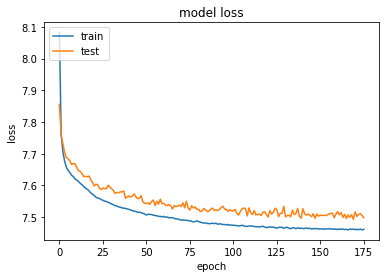

In [37]:
drow_history(vae_history, 'loss')

#### Reconstruction error
* We can see that distribution of reconstruction error is different bwtween Churn and Not Churn customers, but the difference is not big enought to perform classification.

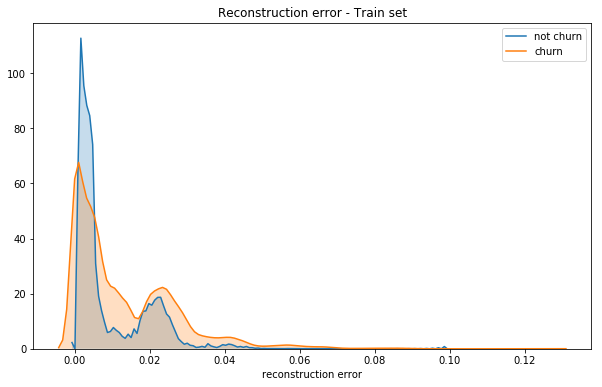

In [38]:
x_train_encoded = encoder.predict(X_train)

pred_train = decoder.predict(x_train_encoded)
mse = np.mean(np.power(X_train - pred_train, 2), axis=1)
error_df = pd.DataFrame({'recon_error': mse,
                        'churn': y_train})

plt.figure(figsize=(10,6))
sns.kdeplot(error_df.recon_error[error_df.churn==0], label='not churn', shade=True, clip=(0,10))
sns.kdeplot(error_df.recon_error[error_df.churn==1], label='churn', shade=True, clip=(0,10))
plt.xlabel('reconstruction error');
plt.title('Reconstruction error - Train set')

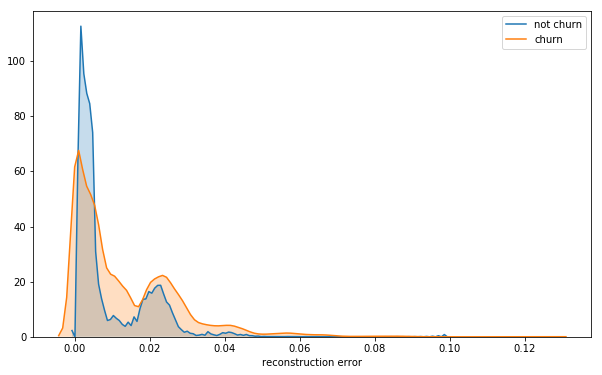

In [39]:
x_train_encoded = encoder.predict(X_train)

pred_train = decoder.predict(x_train_encoded)
mseT = np.mean(np.power(X_train - pred_train, 2), axis=1)
error_df = pd.DataFrame({'recon_error': mseT,
                        'churn': y_train})

plt.figure(figsize=(10,6))
sns.kdeplot(error_df.recon_error[error_df.churn==0], label='not churn', shade=True, clip=(0,10))
sns.kdeplot(error_df.recon_error[error_df.churn==1], label='churn', shade=True, clip=(0,10))
plt.xlabel('reconstruction error');

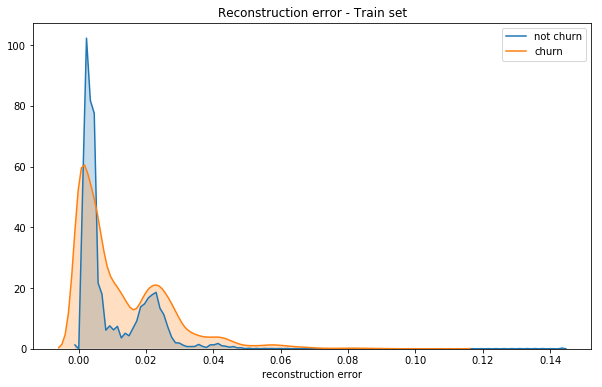

In [40]:
x_val_encoded = encoder.predict(X_val)

pred = decoder.predict(x_val_encoded)
mseV = np.mean(np.power(X_val - pred, 2), axis=1)
error_df = pd.DataFrame({'recon_error': mseV,
                        'churn': y_val})

plt.figure(figsize=(10,6))
sns.kdeplot(error_df.recon_error[error_df.churn==0], label='not churn', shade=True, clip=(0,10))
sns.kdeplot(error_df.recon_error[error_df.churn==1], label='churn', shade=True, clip=(0,10))
plt.xlabel('reconstruction error');
plt.title('Reconstruction error - Train set')

### Latent space
* We can see that Curn and Not Churn customers, can be separable at latent space.

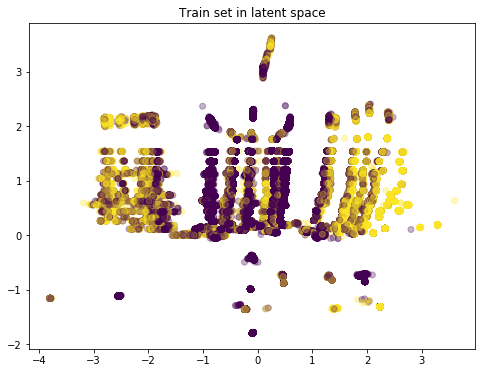

In [41]:
x_train_encoded = encoder.predict(X_train)

plt.figure(figsize=(8, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], 
            c=y_train, alpha=0.3)
plt.title('Train set in latent space')
plt.show()

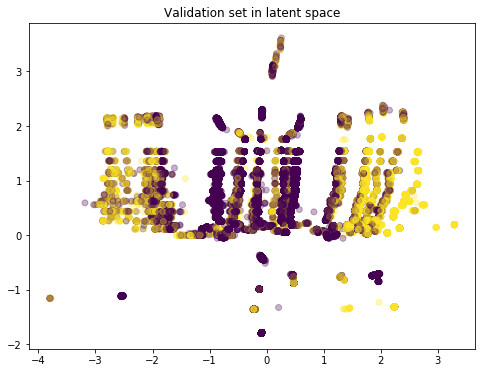

In [42]:
x_val_encoded = encoder.predict(X_val)

plt.figure(figsize=(8, 6))
plt.scatter(x_val_encoded[:, 0], x_val_encoded[:, 1], 
            c=y_val, alpha=0.3)

plt.title('Validation set in latent space')
plt.show()

(1374600, 2) (1374600,) (1374600,) (1374600, 48)


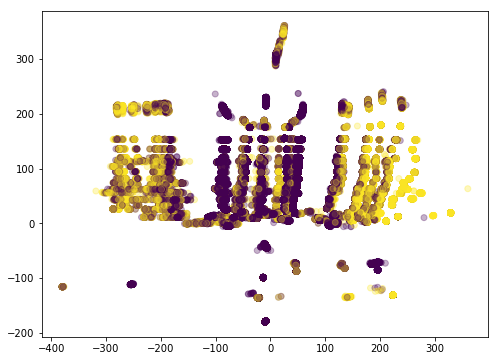

In [43]:
x_train_encoded = encoder.predict(X_train)

print x_train_encoded.shape, x_train_encoded[:, 0].shape, x_train_encoded[:, 1].shape, X_train.shape

#color_bar.set_alpha(1)
plt.figure(figsize=(8, 6))
plt.scatter(100.*x_train_encoded[:, 0], 100.*x_train_encoded[:, 1], 
            c=y_train, alpha=0.3)

plt.show()

### Lest classify in Latent spacw
* Any classification method can be used, lets try nearest neighbour
* Playing with classification parameter to get best prediction on Validation set

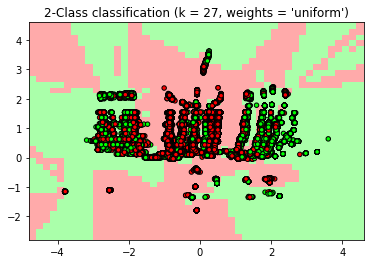

In [44]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
weights='uniform'
n_neighbors=27
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
X=x_train_encoded
y=y_train
clf.fit(X, y)

h=0.2
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-Class classification (k = %i, weights = '%s')"
            % (n_neighbors, weights))

#### Prediction on validation set

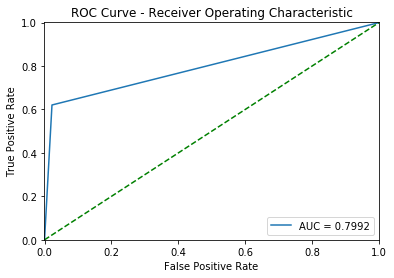

Accuracy: 0.95058, Cohen's Kappa Score: 0.62989
Log Loss: 1.70702453317
 
Confusion Matrix:
[[266131   6057]
 [  8503  13909]]
Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.98      0.97    272188
          1       0.70      0.62      0.66     22412

avg / total       0.95      0.95      0.95    294600



In [45]:
x_val_encoded = encoder.predict(X_val)

y_val_neibghour = clf.predict(x_val_encoded)
drow_roc_curve(y_val, y_val_neibghour)

print_stats(y_val, y_val_neibghour)

#### Prediction on Test set

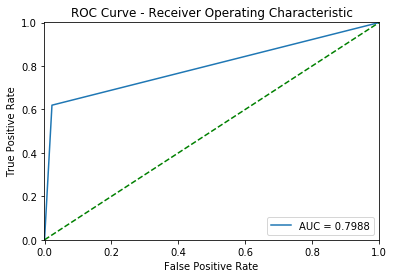

Accuracy: 0.95029, Cohen's Kappa Score: 0.63031
Log Loss: 1.71710708706
 
Confusion Matrix:
[[265927   6039]
 [  8607  14027]]
Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.98      0.97    271966
          1       0.70      0.62      0.66     22634

avg / total       0.95      0.95      0.95    294600



In [46]:
x_test_encoded = encoder.predict(X_test)

y_test_neibghour = clf.predict(x_test_encoded)

drow_roc_curve(y_test, y_test_neibghour)

print_stats(y_test , y_test_neibghour)

* The results are not bad, lets try improve then by adding reconstruction error, to the classification

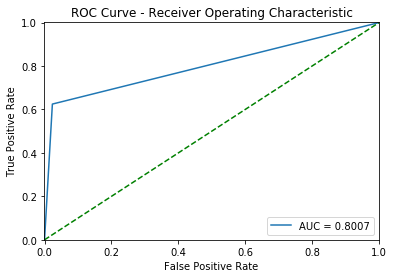

Accuracy: 0.94979, Cohen's Kappa Score: 0.62739
Log Loss: 1.73422500022
 
Confusion Matrix:
[[265804   6384]
 [  8408  14004]]
Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.98      0.97    272188
          1       0.69      0.62      0.65     22412

avg / total       0.95      0.95      0.95    294600



In [47]:
weights='uniform'
n_neighbors=27

clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

X=np.concatenate((x_train_encoded, np.reshape(mse, (mse.shape[0],1))), axis=1)

y=y_train

clf.fit(X, y)
x_val_encoded = encoder.predict(X_val)

vals = np.concatenate((x_val_encoded, np.reshape(mseV, (mseV.shape[0],1))), axis=1)

y_val_neibghour = clf.predict(vals)
drow_roc_curve(y_val, y_val_neibghour)

print_stats(y_val, y_val_neibghour)